# Importing Libraries

In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import combinations
from sklearn.metrics import accuracy_score, roc_auc_score
warnings.filterwarnings('ignore')


In [3]:
matches=pd.read_csv(r'round1_data\match_level_scorecard.csv')
bowlers=pd.read_csv(r'round1_data\bowler_level_scorecard.csv')
batsmans=pd.read_csv(r'round1_data\batsman_level_scorecard.csv')
test=pd.read_csv(r'round1_data\test_data_with_samplefeatures.csv')
train=pd.read_csv(r'round1_data\train_data_with_samplefeatures.csv')

In [4]:
batsmans = batsmans.sort_values('match_dt', ascending=False)
bowlers = bowlers.sort_values('match_dt', ascending=False)
matches = matches.sort_values('match_dt', ascending=False)
train = train.sort_values('match_dt', ascending=False)
test = test.sort_values('match_dt', ascending=False)

# Functions

# 1)-

In [5]:
#********************* For Batsman *****************************

def last_15_match_run(data, batsman_id, match_dt):
    # Filter the data for the specified batsman
    batsman_data = data[data["batsman_id"] == batsman_id]
    batsman_data.reset_index(inplace=True)
    # Find the index where the specified match_id occurs
    match_index = batsman_data[batsman_data["match_dt"] == match_dt].index[0]
    # Calculate the sum of runs for the last 15 matches
    last_15_matches_runs = batsman_data.loc[match_index:match_index+14, "runs"].mean()
    return last_15_matches_runs


In [6]:
batsmans["total_last_15m_runs"]=0

In [7]:
for i in range(batsmans.shape[0]):
    total_last_15m_runs=last_15_match_run(batsmans,batsmans["batsman_id"][i],batsmans["match_dt"][i])
    batsmans["total_last_15m_runs"][i]=total_last_15m_runs

In [8]:
train["Total_run_1"]=0
train["team_1only_avg_runs_last15"]=0
train["Tota_l_run_2"]=0
train["team_2only_avg_runs_last15"]=0
test["Total_run_1"]=0
test["team_1only_avg_runs_last15"]=0
test["Tota_l_run_2"]=0
test["team_2only_avg_runs_last15"]=0

In [9]:
# Linking batsmans data with matches data --- for team 1
def teamonly_avg_runs_last15(l,data,batsmans):
    for i in range(data.shape[0]):
        match_dt = data.loc[i, "match_dt"]
        total_run = 0
        count = 0
        players = data.loc[i, f"team{l}_roster_ids"].split(":")
        players = [float(x) for x in players]
        
        # Filter batsmans DataFrame for the specific match and players
        batsmans_match = batsmans[(batsmans["match_dt"] < match_dt) & (batsmans["batsman_id"].isin(players))]
        
        # Calculate total runs and count for the specific match
        total_run = batsmans_match["total_last_15m_runs"].sum()
        count = batsmans_match.shape[0]
        
        # Assign total runs and average runs to the matches DataFrame
        data.loc[i, f"Total_run_{l}"] = total_run
        data.loc[i, f"team_{l}only_avg_runs_last15"] = total_run / min(count, 15)

    # Ensure that "Total_run" and "team1only_avg_runs_last15" columns are of numeric data type
    data[[f"Total_run_{l}", f"team_{l}only_avg_runs_last15"]] = data[[f"Total_run_{l}", f"team_{l}only_avg_runs_last15"]].astype(float)
    
    return data


In [10]:
train=teamonly_avg_runs_last15(1,train,batsmans)
train=teamonly_avg_runs_last15(2,train,batsmans)
test=teamonly_avg_runs_last15(1,test,batsmans)
test=teamonly_avg_runs_last15(2,test,batsmans)

In [11]:
train['team_12only_avg_runs_last15']=train['team_1only_avg_runs_last15']/train['team_2only_avg_runs_last15']
test['team_12only_avg_runs_last15']=test['team_1only_avg_runs_last15']/test['team_2only_avg_runs_last15']

# 2)-

In [12]:
def last_15_match_wicket(data, bowler_id, match_dt):
    # Filter the data for the specified batsman
    bowler_data = data[data["bowler_id"] == bowler_id]
    bowler_data.reset_index(inplace=True)
    # Find the index where the specified match_id occurs
    last_15_matches_runs = bowler_data[bowler_data["match_dt"] < match_dt]['wicket_count'].head(15).mean()
    # Calculate the sum of runs for the last 15 matches
    # last_15_matches_runs = bowler_data.loc[match_index:match_index+14, "wicket_count"].mean()
    return last_15_matches_runs

In [13]:
bowlers["total_last_15m_wickets"]=0
for i in range(bowlers.shape[0]):
    total_last_15m_wickets=last_15_match_wicket(bowlers,bowlers["bowler_id"][i],bowlers["match_dt"][i])
    bowlers["total_last_15m_wickets"][i]=total_last_15m_wickets

In [14]:
train["Net_Wickets_by_bowlers_of_team1"]=0
train["Net_Wickets_by_bowlers_of_team2"]=0
test["Net_Wickets_by_bowlers_of_team1"]=0
test["Net_Wickets_by_bowlers_of_team2"]=0

In [15]:
def Net_Wickets_by_bowlers_of_team(l, train, bowlers):
    # Initialize the new column with zero values
    train[f"Net_Wickets_by_bowlers_of_team{l}"] = 0.0

    for i in range(train.shape[0]):
        match_dt = train.at[i, "match_dt"]
        player_ids = train.at[i, f"team{l}_roster_ids"].split(":")
        player_ids = [float(x) for x in player_ids]
        net_wicket = 0
        
        # Iterate over each player ID in the roster
        for player_id in player_ids:
            filtered_data = bowlers[(bowlers["bowler_id"] == player_id) & (bowlers["match_dt"] < match_dt)]
            if not filtered_data.empty:
                wickets = filtered_data["total_last_15m_wickets"].head(10).mean()
                if not np.isnan(wickets):  # or pd.notna(wickets)
                    net_wicket += wickets
        
        # Update the DataFrame with the computed net_wicket value
        train.at[i, f"Net_Wickets_by_bowlers_of_team{l}"] = net_wicket
    
    return train


In [16]:
train=Net_Wickets_by_bowlers_of_team(1,train,bowlers)
train=Net_Wickets_by_bowlers_of_team(2,train,bowlers)
test=Net_Wickets_by_bowlers_of_team(1,test,bowlers)
test=Net_Wickets_by_bowlers_of_team(2,test,bowlers)

In [17]:
train['Net_Wickets_by_bowlers_wrt_team12']=train['Net_Wickets_by_bowlers_of_team1']-train['Net_Wickets_by_bowlers_of_team2']
test['Net_Wickets_by_bowlers_wrt_team12']=test['Net_Wickets_by_bowlers_of_team1']-test['Net_Wickets_by_bowlers_of_team2']

# 3)-

In [18]:
df=pd.DataFrame()
df['team1_id']=0
df['night match']=0
df['day/night match']=0
df['day match']=0
lts=matches['lighting'].unique()
team_ids=matches["team1_id"].unique()

In [19]:
i = 0
for id in team_ids:
    for l in lts:  # Renamed to avoid conflict with Python's list keyword
        df.at[i, 'team1_id'] = id
        x = matches[((matches["team1_id"] == id) | (matches["team2_id"] == id)) & (matches["lighting"] == l)]
        
        # Assuming 'runs' is the column in 'match' DataFrame representing the runs
        runs = x['inning1_runs'].sum()
        length = x.shape[0]
        
        # Check if length is not zero to avoid division by zero error
        if length > 0:
            avg = float(runs / length)
        else:
            avg = 0
        
        if l == 'night match':
            df.at[i, 'night match'] = avg
        elif l == 'day/night match':
            df.at[i, 'day/night match'] = avg
        else:
            df.at[i, 'day match'] = avg
    i += 1


In [20]:
train['team1_lighting_performance']=0
train['team2_lighting_performance']=0
test['team1_lighting_performance']=0
test['team2_lighting_performance']=0

In [21]:
def team_lighting_performance(l,match,data):
    for i in range(match.shape[0]):
        team_id = match.loc[i, f'team{l}_id']
        lighting_condition = match.loc[i, 'lighting']
        
        # Get the row from df corresponding to the team_id
        data = df[df['team1_id'] == team_id]
        
        if not data.empty:
            if lighting_condition == 'night match':
                match.loc[i, f'team{l}_lighting_performance'] = data['night match'].values[0]
            elif lighting_condition == 'day/night match':
                match.loc[i, f'team{l}_lighting_performance'] = data['day/night match'].values[0]
            else:
                match.loc[i, f'team{l}_lighting_performance'] = data['day match'].values[0]
    return match

In [22]:
train=team_lighting_performance(1,train,df)
train=team_lighting_performance(2,train,df)
test=team_lighting_performance(1,test,df)
test=team_lighting_performance(2,test,df)


In [23]:
train["team12_lighting_performance"]=train["team1_lighting_performance"]-train["team2_lighting_performance"]
test["team12_lighting_performance"]=test["team1_lighting_performance"]-test["team2_lighting_performance"]


# 4),5)

In [24]:
train['toss_winner_01'] = np.where(train['toss winner']==train['team2'], 1, 0)
train['toss_decision_01'] = np.where(train['toss decision']=='bat', 1, 0)
test['toss_winner_01'] = np.where(test['toss winner']==test['team2'], 1, 0)
test['toss_decision_01'] = np.where(test['toss decision']=='bat', 1, 0)

# 6)-

In [25]:
# Initialize run rate columns
matches['run_rate_team1'] = 0
matches['run_rate_team2'] = 0

# Calculate run rates based on toss winner and toss decision
conditions = [
    (matches['toss winner'] == matches['team1_id']) & (matches['toss decision'] == 'bat'),
    (matches['toss winner'] == matches['team1_id']) & (matches['toss decision'] != 'bat'),
    (matches['toss winner'] != matches['team1_id']) & (matches['toss decision'] == 'bat'),
    (matches['toss winner'] != matches['team1_id']) & (matches['toss decision'] != 'bat')
]

choices_run_rate_team1 = [
    (matches['inning1_runs'] * 6) / matches['inning1_balls'],
    (matches['inning2_runs'] * 6) / matches['inning2_balls'],
    (matches['inning2_runs'] * 6) / matches['inning2_balls'],
    (matches['inning1_runs'] * 6) / matches['inning1_balls']
]

choices_run_rate_team2 = [
    (matches['inning2_runs'] * 6) / matches['inning2_balls'],
    (matches['inning1_runs'] * 6) / matches['inning1_balls'],
    (matches['inning1_runs'] * 6) / matches['inning1_balls'],
    (matches['inning2_runs'] * 6) / matches['inning2_balls']
]

matches['run_rate_team1'] = np.select(conditions, choices_run_rate_team1, default=0)
matches['run_rate_team2'] = np.select(conditions, choices_run_rate_team2, default=0)



In [26]:
def last_nm_runrate_1(n, team1_id, match_dt, matches):
    data = matches[((matches['team1_id'] == team1_id) | (matches['team2_id']==team1_id)) & (matches['match_dt'] < match_dt)]
    data = data.sort_values(by='match_dt', ascending=False)
    length = data.shape[0]
    if length == 0:
        # Handle case where no matches are found
        return 0
    # Compute runs and average
    if length >= n:
        runs = data['run_rate_team1'][:n].sum()
        avg = runs / n
    else:
        runs = data['run_rate_team1'].sum()
        avg = runs / length if length > 0 else 0
    return avg


In [27]:
def last_nm_runrate_2(n, team2_id, match_dt, matches):
    data = matches[((matches['team1_id'] == 'team2_id') | (matches['team2_id']==team2_id)) & (matches['match_dt'] < match_dt)]
    data = data.sort_values(by='match_dt', ascending=False)
    length = data.shape[0]
    if length == 0:
        # Handle case where no matches are found
        return 0
    # Compute runs and average
    if length >= n:
        runs = data['run_rate_team2'][:n].sum()
        avg = runs / n
    else:
        runs = data['run_rate_team2'].sum()
        avg = runs / length if length > 0 else 0
    return avg


In [28]:
train

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,Total_run_2,team_12only_avg_runs_last15,Net_Wickets_by_bowlers_of_team1,Net_Wickets_by_bowlers_of_team2,Net_Wickets_by_bowlers_wrt_team12,team1_lighting_performance,team2_lighting_performance,team12_lighting_performance,toss_winner_01,toss_decision_01
416,9887863,Ud Ab Es,202,8688952.0:7412936.0:8250115.0:8463783.0:988325...,An,293,5554212.0:6818622.0:6450576.0:3668356.0:181404...,Ud Ab Es,202,Ud Ab Es,...,5105.456654,0.301973,6.592377,5.712436,0.879941,160.666667,145.666667,15.000000,0,1
614,9702790,Ae Ss,33914,4239038.0:2161599.0:2286472.0:5469008.0:368195...,Me Rs,33942,4003390.0:2654014.0:8176356.0:46794.0:1635773....,Me Rs,33942,Ae Ss,...,7097.920377,1.004329,7.030667,5.666873,1.363794,161.866667,158.481481,3.385185,0,1
90,9702783,Ht Hs,33928,1611364.0:5843200.0:5716402.0:3890963.0:194364...,Me Ss,33949,5406540.0:2275195.0:2275097.0:3901078.0:796099...,Me Ss,33949,Me Ss,...,7266.352767,0.938345,7.839246,6.954905,0.884341,175.550000,159.307692,16.242308,1,0
21,9866373,Oo,18360,2319638.0:8444855.0:4172706.0:7907444.0:631714...,Wn,18570,9036516.0:8271969.0:3913447.0:9523954.0:835478...,Wn,18570,Oo,...,1220.186916,1.406997,6.473675,3.793591,2.680084,150.500000,154.200000,-3.700000,0,1
93,9717504,Nw Zd,48,6718326.0:4381761.0:2672214.0:5764576.0:306995...,Bh,188,3758565.0:2104332.0:4403419.0:3056752.0:693023...,Bh,188,Bh,...,3693.958974,2.997834,8.536964,4.617715,3.919250,166.333333,141.307692,25.025641,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,8887731,Be Ht,33921,3062149.0:8415665.0:3585350.0:5786766.0:153920...,Me Rs,33942,5406540.0:37351.0:46794.0:2336473.0:7537067.0:...,Me Rs,33942,Me Rs,...,2817.249267,0.432851,1.233333,7.301524,-6.068191,160.200000,158.481481,1.718519,1,0
476,8887717,Ht Hs,33928,4223883.0:1611364.0:2161599.0:2340372.0:584320...,Ae Ss,33914,4239038.0:5492318.0:5056134.0:1635773.0:546900...,Ae Ss,33914,Ae Ss,...,2159.977983,1.519469,4.819040,5.171370,-0.352330,175.550000,161.866667,13.683333,1,0
902,8887703,Me Ss,33949,2340519.0:7880018.0:4393374.0:2275195.0:390107...,Me Rs,33942,5406540.0:37351.0:46794.0:2336473.0:7534687.0:...,Me Rs,33942,Me Ss,...,2815.600061,0.574653,4.774109,5.778397,-1.004288,159.307692,158.481481,0.826211,0,1
298,8887689,Ph Ss,33935,3507090.0:3535783.0:1626526.0:1798705.0:350188...,Me Ss,33949,4003390.0:7960994.0:2275195.0:4393374.0:390107...,Ph Ss,33935,Ph Ss,...,2301.149964,1.370614,7.197884,4.320000,2.877884,172.142857,179.666667,-7.523810,0,1


In [29]:
# APPLYING FUNCTION
train['last_5m_runrate_1']=0
train['last_5m_runrate_2']=0
for i in range(train.shape[0]):
    train['last_5m_runrate_1'][i]=last_nm_runrate_1(5,train['team1_id'][i],train['match_dt'][i],matches)
    train['last_5m_runrate_2'][i]=last_nm_runrate_2(5,train['team2_id'][i],train['match_dt'][i],matches)
# APPLYING FUNCTION
test['last_5m_runrate_1']=0
test['last_5m_runrate_2']=0
for i in range(test.shape[0]):
    test['last_5m_runrate_1'][i]=last_nm_runrate_1(5,test['team1_id'][i],test['match_dt'][i],matches)
    test['last_5m_runrate_2'][i]=last_nm_runrate_2(5,test['team2_id'][i],test['match_dt'][i],matches)

In [30]:
train['last_5m_runrate_12']=train['last_5m_runrate_2']-train['last_5m_runrate_1']
test['last_5m_runrate_12']=test['last_5m_runrate_2']-test['last_5m_runrate_1']

# 7)-

In [31]:
def calculate_team1_winp_team2_last10(data, team1, team2, match_dt):
    relevant_matches = data[
        (((data['team1'] == team1) & (data['team2'] == team2)) | 
         ((data['team1'] == team2) & (data['team2'] == team1))) &
        (data['match_dt']  <match_dt)
    ]
    
    relevant_matches = relevant_matches.head(10)
    
    team1_wins = sum(
        ((relevant_matches['team1'] == team1) & (relevant_matches['winner'] == team1)) | 
        ((relevant_matches['team2'] == team1) & (relevant_matches['winner'] == team1))
    )
    
    total_matches = len(relevant_matches)
    
    if total_matches == 0:
        win_percentage = 0.0
    else:
        win_percentage = (team1_wins / total_matches) * 100
    
    return win_percentage

In [32]:
train['team1_winp_team2_last10']=0

In [33]:
def calculate_team1_wrt2last15(data):
    for idx in range(len(data)):
        match_dt=data['match_dt'][idx]
        team1 = data.iloc[idx]['team1']
        team2 = data.iloc[idx]['team2']
        win_percentage = calculate_team1_winp_team2_last10(data, team1, team2, match_dt)
        data.at[data.index[idx], 'team1_winp_team2_last10'] = win_percentage

In [34]:
calculate_team1_wrt2last15(train)

In [35]:
train['winner_01']=np.where(train["winner_id"]==train['team1_id'],0,1)

In [36]:
train.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'Total_run_1', 'team_1only_avg_runs_last15',
       'Tota_l_run_2', 'team_2only_avg_runs_last15', 'Total_run_2',
       'team_12only_avg_runs_last15', 'Net_Wickets_by_bowlers_of_team1',
       'Net_Wickets_by_bowlers_of_team2', 'Net_Wickets_by_bowlers_wrt_team12',
       'team1_lighting_performance', 'team2_lighting_performance',
       'team12_lighting_performance', 'toss_winner_01', 'toss_decision_01',
       'last_5m_runrate_1', 'last_5m_runrate_2', 'last_5m_runrate_12',
       'team1_winp_team2_last10', 'winner_01'],
      dtype='object')

# *We made total 20 features in which we select top 12 features by using famous algorithm for feature selection (LASSO or L1 Regularization)*

# *******************************************************************************

# Creating feature embedding by Using SVM and Random Forest

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.DataFrame(train, columns=['last_5m_runrate_12', 'team1_winp_team2_last10', 'team12_lighting_performance', 'Net_Wickets_by_bowlers_wrt_team12'])
df['target'] = train['winner_01']


In [38]:
from itertools import combinations

# Generate pairwise combinations of the 4 features
feature_pairs = list(combinations(df.columns[:-1], 2))

# Create a new DataFrame with these pairwise features
pairwise_df = pd.DataFrame()

for i, (f1, f2) in enumerate(feature_pairs):
    pairwise_df[f'pair_{i+1}'] = df[f1] * df[f2]

pairwise_df['target'] = df['target']


In [39]:
from sklearn.ensemble import RandomForestClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(pairwise_df.drop(columns=['target']), pairwise_df['target'], test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_feature_importances = rf.feature_importances_


In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Scale the features and train an SVM model
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
svm.fit(X_train, y_train)

# Extract the SVM coefficients
svm_coefficients = svm.named_steps['svc'].coef_.flatten()


In [41]:
# Generate pairwise combinations of the 4 features
feature_pairs = list(combinations(df.columns[:-1], 2))

# Create a new DataFrame with these pairwise features
pairwise_df = pd.DataFrame()

for i, (f1, f2) in enumerate(feature_pairs):
    pairwise_df[f'pair_{i+1}'] = df[f1] * df[f2]

pairwise_df['target'] = df['target']

# Split the data
X_train = pairwise_df.drop(columns=['target'])
y_train = pairwise_df['target']

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_feature_importances = rf.feature_importances_

# Train an SVM model
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
svm.fit(X_train, y_train)
svm_coefficients = svm.named_steps['svc'].coef_.flatten()

# Create a DataFrame to hold the feature embeddings
feature_embeddings = pd.DataFrame({
    'feature_pair': [f'{pair[0]} * {pair[1]}' for pair in feature_pairs],
    'rf_importance': rf_feature_importances,
    'svm_coefficient': svm_coefficients
})

print(feature_embeddings)


                                        feature_pair  rf_importance  \
0       last_5m_runrate_12 * team1_winp_team2_last10       0.119312   
1   last_5m_runrate_12 * team12_lighting_performance       0.222677   
2  last_5m_runrate_12 * Net_Wickets_by_bowlers_wr...       0.216089   
3  team1_winp_team2_last10 * team12_lighting_perf...       0.107384   
4  team1_winp_team2_last10 * Net_Wickets_by_bowle...       0.105645   
5  team12_lighting_performance * Net_Wickets_by_b...       0.228892   

   svm_coefficient  
0         0.295664  
1        -0.218414  
2        -0.058663  
3        -0.162964  
4        -0.322371  
5        -0.329272  


# Here we find the best 2 pairs for applying PCA 
* last_5m_runrate_12', 'team1_winp_team2_last10', 'team12_lighting_performance', 'Net_Wickets_by_bowlers_wrt_team12

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a DataFrame
df = pd.DataFrame(train, columns=['last_5m_runrate_12', 'team1_winp_team2_last10'])
df1 = pd.DataFrame(train, columns=['team12_lighting_performance', 'Net_Wickets_by_bowlers_wrt_team12'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data1 = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=1)
principal_component = pca.fit_transform(scaled_data)
principal_component1 = pca.fit_transform(scaled_data1)

# Add the principal component to the DataFrame
train['pca1'] = principal_component
train['pca2'] = principal_component1


# Model Training

In [43]:
train.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'Total_run_1', 'team_1only_avg_runs_last15',
       'Tota_l_run_2', 'team_2only_avg_runs_last15', 'Total_run_2',
       'team_12only_avg_runs_last15', 'Net_Wickets_by_bowlers_of_team1',
       'Net_Wickets_by_bowlers_of_team2', 'Net_Wickets_by_bowlers_wrt_team12',
       'team1_lighting_performance', 'team2_lighting_performance',
       'team12_lighting_performance', 'toss_winner_01', 'toss_decision_01',
       'last_5m_runrate_1', 'last_5m_runrate_2', 'last_5m_runrate_12',
       'team1_winp_team2_last10', 'winner_01', 'pca1', 'pca2'],
      dtype='object')

In [44]:
X=train[['team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15','team_12only_avg_runs_last15',
       'pca2','pca1', 'toss_winner_01', 'toss_decision_01',
       ]]
y=train['winner_01']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)


In [56]:
X_train.columns

Index(['team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_12only_avg_runs_last15', 'pca2', 'pca1',
       'toss_winner_01', 'toss_decision_01'],
      dtype='object')

In [46]:
# Initialize XGBoost model with binary:logistic objective
model = xgb.XGBClassifier(objective='binary:logistic')

# Train the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6639676113360324
ROC AUC: 0.7123000262260687


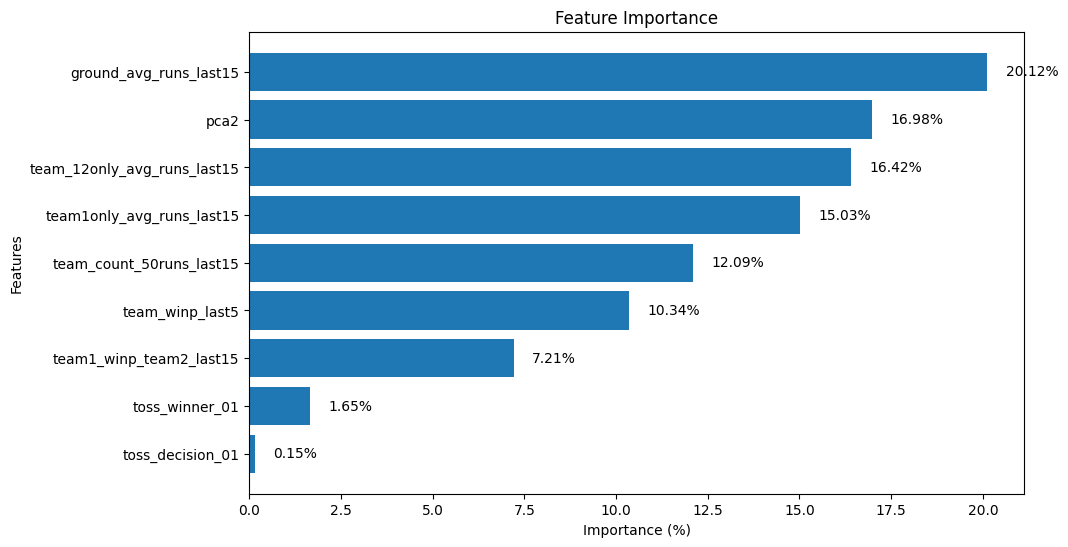

In [58]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have trained an XGBoost model and stored it in `model`

# Extract feature importance
importance = model.get_booster().get_score(importance_type='weight')

# Calculate total sum of importance scores
total_importance = sum(importance.values())

# Sort feature importance dictionary by values (importance score)
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Separate feature names and importance scores for plotting
features = [x[0] for x in importance]
scores = [x[1] for x in importance]

# Calculate percentages
percentages = [score / total_importance * 100 for score in scores]

# Plotting the feature importance as percentages
plt.figure(figsize=(10, 6))
bars = plt.barh(features, percentages, align='center')

# Add percentage values to each bar
for bar, percent in zip(bars, percentages):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{percent:.2f}%', 
             va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [59]:
X_train.columns

Index(['team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_12only_avg_runs_last15', 'pca2', 'pca1',
       'toss_winner_01', 'toss_decision_01'],
      dtype='object')

In [48]:


# HOW TO RUN - data1 represent train data which contains 10 features with team1_id,team2_id and winner_id
# data2 represent test data which contains 10 features with team1_id,team2_id

def final_form(data1,data2): #train,test
    data1.fillna(0,inplace=True)
    data2.fillna(0,inplace=True)
    X=data1[['team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15','team_12only_avg_runs_last15',
       'Net_Wickets_by_bowlers_wrt_team12','team12_lighting_performance', 'toss_winner_01', 'toss_decision_01',
       ]]
    y=data1['winner_01']
    X_test = data2[X.columns.tolist()]
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    model.fit(X, y)
    data1['y_pred_01'] = model.predict(X)
    data2['y_pred_01'] = model.predict(X_test)
    data1['win_pred_score'] = model.predict_proba(X)[:,1]
    data2['win_pred_score'] = model.predict_proba(X_test)[:,1]
    data1['win_pred_score'] = np.where( (data1['y_pred_01']==0), (1-data1['win_pred_score']), data1['win_pred_score'])
    data2['win_pred_score'] = np.where( (data2['y_pred_01']==0), (1-data2['win_pred_score']), data2['win_pred_score'])
    data1['win_pred_team_id'] = np.where( (data1['y_pred_01']==0), (data1['team1_id']), data1['team2_id'])
    data2['win_pred_team_id'] = np.where( (data2['y_pred_01']==0), (data2['team1_id']), data2['team2_id'])
    df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':model.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)
    data1['dataset_type'] = 'train'
    data2['dataset_type'] = 'r1'
    
    ## refactor

    df_file1 = pd.concat([data2[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                        data1[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

    renaming_dict = {}
    for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
        renaming_dict[col] = f'indep_feat_id{i+1}'
    df_file1.rename(columns=renaming_dict, inplace=True)

    for i in range(1,11):
        if f'indep_feat_id{i}' not in df_file1.columns:
            df_file1[f'indep_feat_id{i}'] = np.nan

    df_file1['train_algorithm'] = 'XGBoost'
    df_file1['is_ensemble'] = 'No'
    df_file1['train_hps_trees'] = '100'
    df_file1['train_hps_depth'] = '6'
    df_file1['train_hps_lr'] = '0.01'
    
    feature_desc = {'Team1_last10m_strike_rate':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
               'team1_proximity_to_50th_percentile':'Ratio of team1\'s win % to team2\'s win % in last 5 games',\
               'toss_decision_01':'average runs scored in the ground in last 15 games',\
               'team2_avg15_runs':'Team1\'s win percentage against Team2 in last 15 games',\
               'head_to_head_win_rate':'team1\'s avg inning runs in last 15 games',\
                'team1_recent_performance_gap':'team1\'s avg inning runs in last 5 games',\
                'team1_last_5_win_rate':'team1\'s recent 5 match win ratio games',\
               'team1_weighted_avg' : 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',\
               'toss_winner_01' : 'Toss winner to numerical - 1 if team2 wins, else 0',\
               '50_percentile_runs_for_winning' : 'Toss decision - categorical - 1 if winner bats, 0 otherwise'}
    
    
    # df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
    df_file2 = df_feat_importance
    df_file2['feat_id'] = [i+1 for i in df_file2.index]
    df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
    df_file2 = df_file2.set_index('feat_id')
    df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

    df_file1.to_csv('file1.csv', index=False)
    df_file2.to_csv('file2.csv')

In [49]:
train.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'Total_run_1', 'team_1only_avg_runs_last15',
       'Tota_l_run_2', 'team_2only_avg_runs_last15', 'Total_run_2',
       'team_12only_avg_runs_last15', 'Net_Wickets_by_bowlers_of_team1',
       'Net_Wickets_by_bowlers_of_team2', 'Net_Wickets_by_bowlers_wrt_team12',
       'team1_lighting_performance', 'team2_lighting_performance',
       'team12_lighting_performance', 'toss_winner_01', 'toss_decision_01',
       'last_5m_runrate_1', 'last_5m_runrate_2', 'last_5m_runrate_12',
       'team1_winp_team2_last10', 'winner_01', 'pca1', 'pca2'],
      dtype='object')

In [50]:
final_form(train,test)

In [51]:
file1=pd.read_csv('file1.csv')
file2=pd.read_csv('file2.csv')

In [52]:
file1

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9717518,r1,48,0.779991,0,1.655738,0.866667,-31.417544,139.000000,-3.900849,153.400000,0.343783,40.0,1,XGBoost,No,100,6,0.01
1,9702776,r1,33963,0.747748,1,3.857143,0.461538,-2.920000,163.300000,-1.470413,163.800000,0.926874,60.0,0,XGBoost,No,100,6,0.01
2,9702748,r1,33949,0.935379,1,0.047619,0.692308,5.666667,197.000000,0.023315,159.333333,0.975383,50.0,0,XGBoost,No,100,6,0.01
3,9615087,r1,41,0.877046,0,1.000000,0.800000,13.944444,151.625000,1.913555,174.266667,1.510928,60.0,1,XGBoost,No,100,6,0.01
4,9615073,r1,20,0.702778,0,2.904762,0.923077,-20.095238,159.400000,-2.277160,169.600000,0.700796,60.0,1,XGBoost,No,100,6,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,8887731,train,33942,0.971256,0,1.952381,0.363636,1.718519,0.000000,-6.068191,167.000000,0.432851,100.0,1,XGBoost,No,100,6,0.01
1215,8887717,train,33914,0.916199,0,61.000000,1.000000,13.683333,161.045455,-0.352330,173.333333,1.519469,100.0,1,XGBoost,No,100,6,0.01
1216,8887703,train,33942,0.990958,1,41.000000,0.400000,0.826211,162.687500,-1.004288,171.066667,0.574653,50.0,0,XGBoost,No,100,6,0.01
1217,8887689,train,33935,0.970310,1,1.327869,1.222222,-7.523810,0.000000,2.877884,178.733333,1.370614,100.0,0,XGBoost,No,100,6,0.01
